<h3>Import Libraries</h3>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

<h3>1. Load the Data</h3>

In [2]:

customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')
products_df = pd.read_csv('Products.csv')

<h3>2. Merge DataFrames (Customers + Transactions + Products)</h3>

In [3]:
merged_df = pd.merge(transactions_df, customers_df, on="CustomerID", how="inner")
merged_df = pd.merge(merged_df, products_df, on="ProductID", how="inner")

<h3>3. Aggregate Transaction Data for Each Customer</h3>

In [4]:
customer_agg = merged_df.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    purchase_count=('TransactionID', 'count'),
    avg_spent_per_transaction=('TotalValue', 'mean'),
    most_common_category=('Category', lambda x: x.mode()[0])  # Most frequent product category
).reset_index()

<h3>4. Merge with Customer Demographics (Region, etc.)</h3>

In [5]:
customer_features = pd.merge(customers_df[['CustomerID', 'Region']], customer_agg, on='CustomerID')

<h3>5. One-hot Encode the Categorical Data (Region)</h3>

In [6]:
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

<h3>6. Separate Numerical and Categorical Features</h3>

In [7]:
numerical_columns = ['total_spend', 'purchase_count', 'avg_spent_per_transaction']
categorical_columns = [col for col in customer_features.columns if 'Region_' in col]

# Separate the numerical features for scaling
numerical_data = customer_features[numerical_columns]

# Apply StandardScaler to the numerical features only
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(numerical_data)

<h3>7. Combine Scaled Numerical Features with Categorical Features</h3>

In [8]:
scaled_customer_features = pd.DataFrame(scaled_numerical_data, columns=numerical_columns)
categorical_data = customer_features[categorical_columns]

# Combine scaled numerical features with categorical features
final_customer_features = pd.concat([scaled_customer_features, categorical_data], axis=1)

<h3>8. Apply K-Means Clustering (with clusters between 2 and 10)</h3>

In [9]:
# List to store metrics
db_index_scores = []
silhouette_scores = []
k_range = range(2, 11)

# Apply KMeans for different K values and calculate metrics
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_customer_features)
    labels = kmeans.labels_

    # Calculate Davies-Bouldin Index (DBI)
    dbi = davies_bouldin_score(final_customer_features, labels)
    db_index_scores.append(dbi)

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(final_customer_features, labels)
    silhouette_scores.append(silhouette_avg)



<h3>9. Find the Best K based on DB Index and Silhouette Score</h3>

In [10]:
best_k = k_range[np.argmin(db_index_scores)]  # The best K corresponds to the minimum DBI
best_silhouette = max(silhouette_scores)     # The best K corresponds to the highest silhouette score

<h3>10. Final Clustering with Best K</h3>

In [11]:
best_kmeans = KMeans(n_clusters=best_k, random_state=42)
best_kmeans.fit(final_customer_features)
final_labels = best_kmeans.labels_

<h3>11. Add Cluster Labels to the Data</h3>

In [12]:
customer_features['Cluster'] = final_labels

<h3>12. Evaluate</h3>

In [13]:
print(f'Best Number of Clusters (K): {best_k}')
print(f'Davies-Bouldin Index for Best K: {db_index_scores[np.argmin(db_index_scores)]}')
print(f'Silhouette Score for Best K: {best_silhouette}')

Best Number of Clusters (K): 9
Davies-Bouldin Index for Best K: 1.2194787754847871
Silhouette Score for Best K: 0.3098174947993017


<h3>13. Visualize</h3>

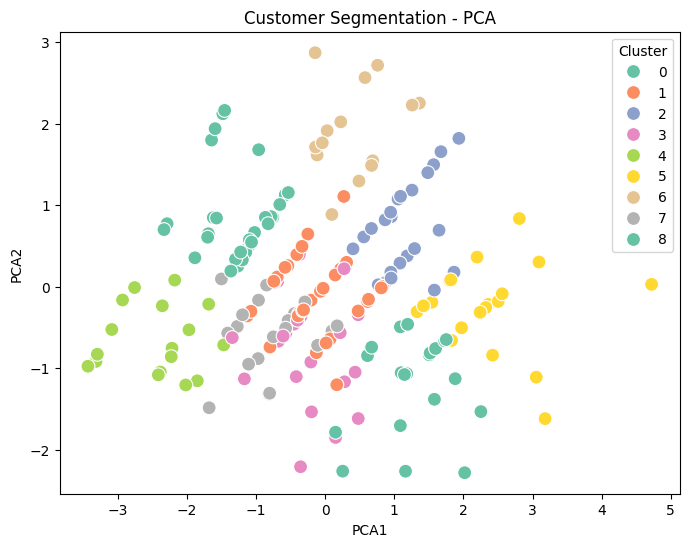

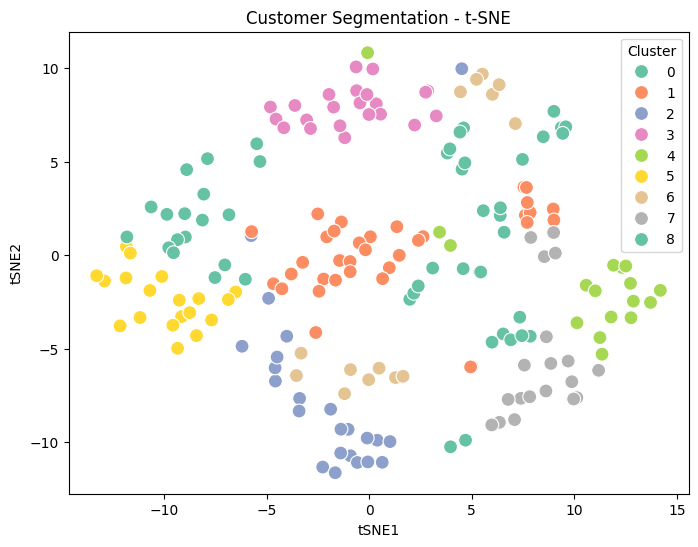

In [14]:
# Visualize the clusters using PCA and t-SNE

# PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(final_customer_features)

# t-SNE for better visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(final_customer_features)

# Create a DataFrame for PCA and t-SNE results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = final_labels

# Plot PCA result
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='Set2', s=100)
plt.title('Customer Segmentation - PCA')
plt.show()

# Create DataFrame for t-SNE result
tsne_df = pd.DataFrame(tsne_result, columns=['tSNE1', 'tSNE2'])
tsne_df['Cluster'] = final_labels

# Plot t-SNE result
plt.figure(figsize=(8, 6))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='Cluster', data=tsne_df, palette='Set2', s=100)
plt.title('Customer Segmentation - t-SNE')
plt.show()
